In [174]:
import sys
import torch  
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

# hyperparameters
hidden_size = 256
learning_rate = 1e-4

# Constants
GAMMA = 0.99
num_steps = 50
max_episodes = 1000

In [175]:
# don't like it as one, better to keep them separate and update weights separately for clearer understanidng
class Actor (nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size):
        super(Actor, self).__init__()
        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        hidden = F.relu(self.actor_linear1(state))
        action = F.softmax(self.actor_linear2(hidden), dim=0)
        return action

class Critic (nn.Module):
    def __init__(self, num_inputs, hidden_size):
        super(Critic, self).__init__()
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)
    
    def forward(self, state, action):
        input = torch.cat((state, action), 0)
        hidden = F.relu(self.critic_linear1(input))
        value = self.critic_linear2(hidden)
        return value

# class ActorCritic(nn.Module):
#     def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
#         super(ActorCritic, self).__init__()

#         self.num_actions = num_actions
#         self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
#         self.critic_linear2 = nn.Linear(hidden_size, 1)

#         self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
#         self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
#     def forward(self, state):
#         state = Variable(torch.from_numpy(state).float().unsqueeze(0))
#         value = F.relu(self.critic_linear1(state))
#         value = self.critic_linear2(value)
        
#         policy_dist = F.relu(self.actor_linear1(state))
#         policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

#         return value, policy_dist

def calc_reward(w, x):
  #have to reindex w according to user preferences in input before doing this
  ordered = []
  for i in range(len(w)):
    ordered.append((x[8+i], w[i]))
  ordered.sort()
  user_pref = 1*(ordered[0][1]>ordered[1][1] and ordered[0][1]>ordered[2][1] \
               and ordered[0][1]>ordered[3][1]) \
                 + 0.5*(ordered[1][1]>ordered[2][1] and ordered[1][1]>ordered[3][1]) \
                   + 0.25*(ordered[2][1]>ordered[3][1]) 
  cost = -0.01 * torch.dot(w, x[4:8])
  net_perf = torch.dot(w, x[0:4]) 
  return user_pref + cost + net_perf
  #return w[0]


In [233]:
actor_input_dims = 3 * 4 # input dimensionality: delays, costs and user preferences for 4 tunnels
actor_output_dims = 4 # 4 weights

critic_input_dims = 4 * 4 #state + action
critic_output_dims = 1 # value


actor = Actor(actor_input_dims, actor_output_dims, hidden_size)
critic = Critic(critic_input_dims, hidden_size)
actor_optimizer = optim.SGD(actor.parameters(), lr=learning_rate)
#scheduler = optim.lr_scheduler.LinearLR(actor_optimizer, start_factor=1e-5, end_factor=1e-6, total_iters=300)
critic_optimizer = optim.SGD(critic.parameters(), lr=learning_rate)
#scheduler = optim.lr_scheduler.LinearLR(critic_optimizer, start_factor=1e-5, end_factor=1e-6, total_iters=300)

fixed_x = torch.FloatTensor([[100,20,50,79],
     [2,4,1,3]]) # first row for costs, second is preference

all_lengths = []
average_lengths = []
all_rewards = []
all_states = []
all_actions = []
all_errors = []
advantages= []

#main loop
for episode in range(max_episodes):
     states = []
     actions = []
     values = []
     rewards = []
     raw_weights = torch.rand(1,4)
     state = torch.cat((raw_weights, fixed_x)).flatten()
     for steps in range(num_steps):
          states.append(state)
          all_states.append(raw_weights.detach().numpy())
          action = actor(state)
          #action = action
          actions.append(action)
          all_actions.append(action.detach().numpy())

          value = critic(state, action)
          #value = value

          raw_weights = torch.rand(1,4)
          state = torch.cat((raw_weights, fixed_x)).flatten()
          reward = calc_reward(action, state)

          rewards.append(reward)
          values.append(value)

          if steps == num_steps-1:
               Qval = critic(state, action)
               Qval = Qval.detach().numpy()
               all_rewards.append(sum(rewards).detach().numpy())
               all_lengths.append(steps)
               average_lengths.append(np.mean(all_lengths[-10:]))
               if episode % 10 == 0:
                    print(action)                    
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, sum(rewards), steps, average_lengths[-1]))
               break
     
     critic_optimizer.zero_grad()
     actor_optimizer.zero_grad()

     actor_loss = -torch.mean(torch.stack(values))
     actor_loss.backward(retain_graph=True)
     actor_optimizer.step()
     
     # compute Q values
     values_tensor = torch.Tensor(values)
     Qvals = torch.zeros_like(values_tensor)
     Qvals[-1] = rewards[-1]
     for t in reversed(range(len(rewards)-1)):
          #Qval is the TD Target rewards[t] is current reward + discounted expected future rewards (thus why backward)
          #starts at 0
          #different articles defining this differently, some are saying it should be gamma*values[t]
          Qval = rewards[t] + GAMMA * values[t+1]
          Qvals[t] = Qval

     # compute advantage (assuming Adv = TD Error = TD Target - V(S))
     advantage = Qvals - values_tensor


     # update critic network by backpropagating the mean squared error between Qvals and values (TD error)
     critic_loss = 0.5*(advantage.pow(2)).mean()
     critic_loss.backward(retain_graph=True)
     critic_optimizer.step()

     advantages.append(np.mean(advantage.detach().numpy()))

     # wrong way to update actor network
     # errors = []
     # # following from paper: use advantage*gradients of actions wrt params to update actor network parameters 
     # for i in range(len(actions)):
     #      #still need to understand logic behind action = log prob of other actions
     #      actor_update= -sum(advantage[i] * actions[i]) #wrong
     #      # computes gradient of actor_update wrt params which should be equal to 
     #      # advantage[i] * gradient of output wrt params since adv does not depend on actor.parameters
     #      # thus would be same as equation from paper
     #      actor_update.backward(retain_graph=True)
     #      errors.append(actor_update.detach().numpy())
     # actor_optimizer.step()

     #getting stuck at local optimum + nan after 40th episode consistently
     #add noise to actions to encourage exploration
     #hyperparameter tuning - grid search? Random search?


tensor([9.5235e-01, 7.1510e-03, 1.9780e-11, 4.0499e-02],
       grad_fn=<SoftmaxBackward0>)
episode: 0, reward: 12.850055694580078, total length: 49, average length: 49.0 


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [256, 4]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

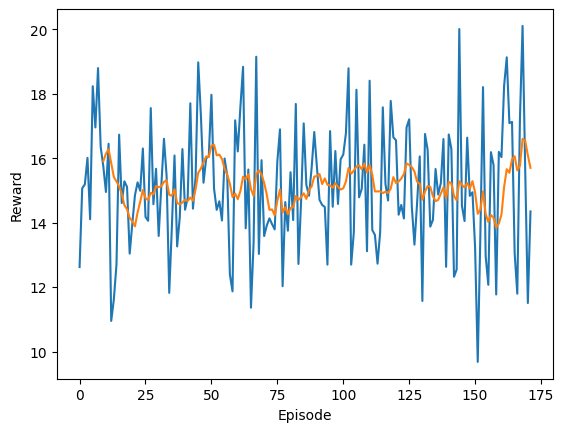

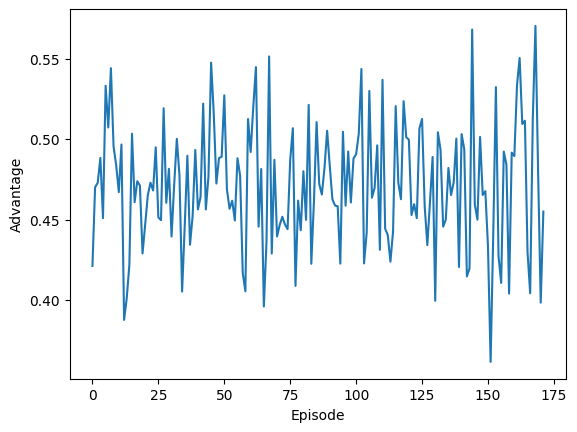

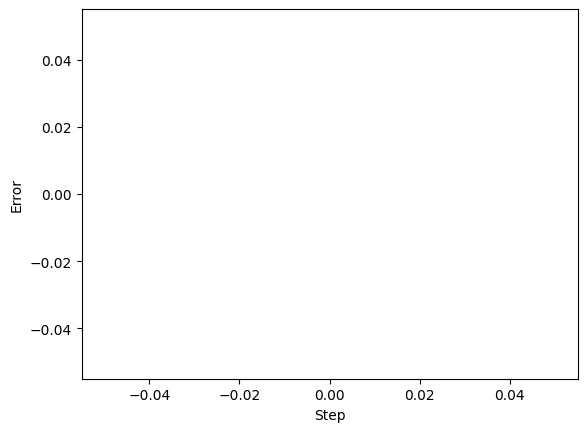

ValueError: x and y can be no greater than 2D, but have shapes (8600,) and (8600, 1, 4)

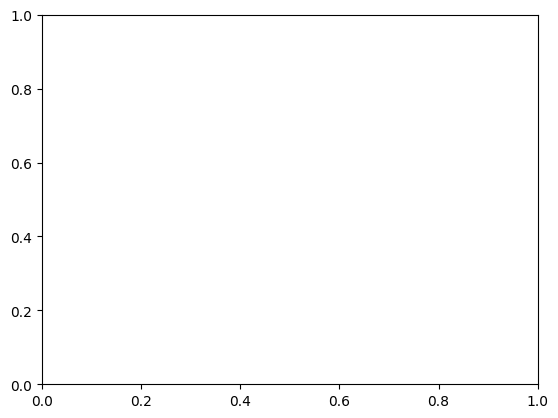

In [224]:
#plot rewards
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards] 
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

#plot advantage (critic network error)
plt.plot(advantages)
plt.xlabel('Episode')
plt.ylabel('Advantage')
plt.show()

#plot errors
plt.plot(all_errors)
plt.xlabel('Step')
plt.ylabel('Error')
plt.show()

#plot states
plt.plot(all_states)
plt.xlabel('Step')
plt.ylabel('State')
plt.show()

#plot actions
plt.plot(all_actions)
plt.xlabel('Step')
plt.ylabel('Action')
plt.show()